## Installs

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 9.6 MB/s eta 0:00:00


## Imports


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch
import torch.nn as nn
from pyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import time

## Deep Learning Model
(Bayesian Neural Network)

In [ ]:
class BNN(PyroModule):
  def __init__(self, inp_dim=1, n_layers=2, out_dim=1, hid_dim=10, pri_scl=5., activ="tanh", reshape = True):
    super().__init__()
    self.activation=nn.Tanh()
    if(activ=="relu"):
      self.activation = nn.ReLU()

    self.reshape = reshape

    self.l_sz_list = []
    self.l_sz_list.append(inp_dim)
    for i in range(n_layers):
      self.l_sz_list.append(hid_dim)

    self.l_sz_list.append(out_dim)
    # layer info
    self.layer_configs = []
    for i in range(1, len(self.l_sz_list)):
      self.layer_configs.append(PyroModule[nn.Linear](self.l_sz_list[i-1], self.l_sz_list[i]))

    self.layers= PyroModule[torch.nn.ModuleList](self.layer_configs)

    for index, layer in enumerate(self.layers):
      layer.weight = PyroSample(dist.Normal(0., pri_scl*np.sqrt(2 / self.l_sz_list[index])).expand([self.l_sz_list[index + 1], self.l_sz_list[index]]).to_event(2))
      layer.bias = PyroSample(dist.Normal(0., pri_scl).expand([self.l_sz_list[index + 1]]).to_event(1))

  def forward(self, x, y=None):
    if self.reshape is True:
      x = x.reshape(-1, 1)
    x = self.activation(self.layers[0](x))
    for i in range(1, len(self.layers)-1):
      x = self.activation(self.layers[i](x))

    mu = self.layers[-1](x).squeeze()
    sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # for noise

    # for sampling
    with pyro.plate("data", x.shape[0]):  # pyro plate is a context manager for handling collection of data points
      obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

    return mu

##Plotter

In [ ]:
def plot_data(preds, x_test, x_obs, y_obs, x_true, y_true):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    #setting the plot configs
    fig, ax = plt.subplots(figsize=(10,5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observed values")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#FF0000", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#FF7F7F', zorder=5)

    plt.legend(loc=4, fontsize=16, frameon=False)

## Data Generation
The function considered in this case is: $y = x + sin(\frac{\pi}{2}x) + sin(\pi x)$.

For this the samples ($x$) are randomly sampled from uniform distribution and corresponding $y$'s are computed after introducing some random noise (for $x\_obs$ and $y\_obs$).

In [ ]:
np.random.seed(int(time.time())) # random seed

# sampling observations
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(0.5 * np.pi * (x_obs + noise)) + 0.3 * np.sin(np.pi * (x_obs + noise)) + noise

# sampling the true points
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(0.5 * np.pi * x_true) + 0.3 * np.sin(np.pi * x_true)

<class 'numpy.ndarray'>


##Model Training

In [ ]:
model = BNN(hid_dim=10, n_layers=5)
pyro.set_rng_seed(int(time.time()))
nuts_kernel = NUTS(model, jit_compile=True) # NUTS kernel for Hamiltonian Monte Carlo (jit_compile makes it faster)
mcmc = MCMC(nuts_kernel, num_samples=100)
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
mcmc.run(x_train, y_train)

##Predictions


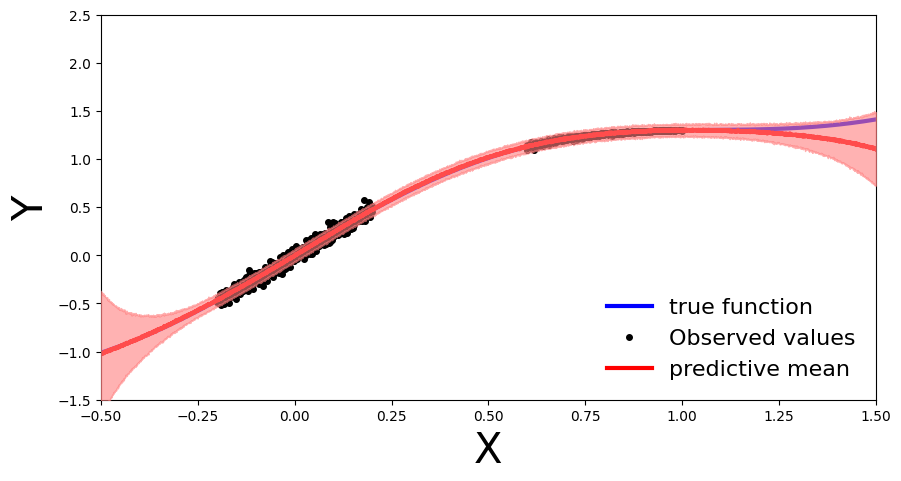

In [ ]:
pred_model = Predictive(model = model, posterior_samples=mcmc.get_samples())
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = pred_model(x_test)
plot_data(preds, x_test, x_obs, y_obs, x_true, y_true)

## Testing on publicly available datasets
(i) Experience-Salary Dataset

<ul>
<b>Input:</b>
<li><i>Experience - in months</i></li>

<b>Output:</b>
<li><i>Salary - in thousands of $</i></li>
</ul>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('./experience_salary.csv')
data

,exp(in months),salary(in thousands)
0,18.290293,16.521825
1,17.023407,11.666234
2,26.343613,23.167255
3,19.105834,20.877145
4,27.742516,23.166236
...,...,...
995,22.161741,24.666502
996,32.266497,24.160270
997,17.039030,19.903797
998,25.222124,21.974413


In [ ]:
data.dtypes

exp(in months)          float64
salary(in thousands)    float64
dtype: object

##Test-Train Split(25 - 75)

In [ ]:
x = data["exp(in months)"]
y = data["salary(in thousands)"]
x_train, x_test, y_train, y_test = train_test_split(x,y , random_state=int((time.time())%1000),  test_size=0.25,  shuffle=True)

## Training the model


In [ ]:
model1 = BNN(hid_dim=10, n_layers=5)
pyro.set_rng_seed(int(time.time()))
nuts_kernel1 = NUTS(model1, jit_compile=True)
mcmc = MCMC(nuts_kernel1, num_samples=100)
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()
mcmc.run(x_train, y_train)

Warmup:   0%|          | 0/200 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 200/200 [19:01,  5.71s/it, step size=1.76e-03, acc. prob=0.850]


## Testing

In [ ]:
pred_model1 = Predictive(model = model1, posterior_samples=mcmc.get_samples())
x_test_tensor =torch.from_numpy(x_test.to_numpy()).float()
y_test_arr = y_test.to_numpy()
preds = pred_model1(x_test_tensor)
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
mse = 0.0
for i in range(len(y_pred)):
  mse += (y_pred[i]-y_test_arr[i])**2

mse /= len(y_pred)
print(f"The mean squared error(mse) is found to be:", mse)

The mean squared error(mse) is found to be: 31.105180972551565


##Plots

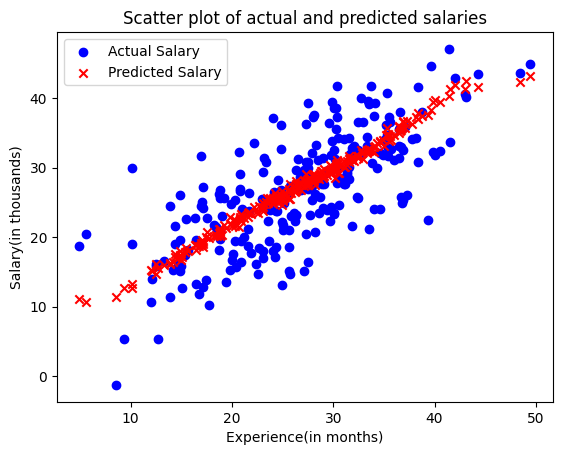

In [ ]:
plt.scatter(x_test, y_test, label = "Actual Salary", color = "blue")
plt.scatter(x_test, y_pred, label = "Predicted Salary", color = "red", marker = "x")
plt.xlabel('Experience(in months)')
plt.ylabel('Salary(in thousands)')
plt.title('Scatter plot of actual and predicted salaries')
plt.legend()

plt.show()

(ii)Admission Prediction Dataset
<ul>
<b>Input:</b>
<li><i>GRE Score: int</i></li>
<li><i>TOEFL Score: int</i></li>
<li><i>University Rating: int (0-5)</i></li>
<li><i>SOP: float</i></li>
<li><i>LOR: float </i></li>
<li><i>CGPA: float </i></li>
<li><i>Research: boolean</i></li>

<b>Output:</b>
<li><i>Chance of Admit: float (percentage)</i></li>
</ul>

In [ ]:
data2 = pd.read_csv('./Admission_Predict.csv')
data2

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [ ]:
data2.dtypes

Serial No.             int64
GRE Score            float64
TOEFL Score          float64
University Rating    float64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

## Normalization of the columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']
scaler = MinMaxScaler()
data2[columns_to_normalize] = data2[columns_to_normalize].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
data2

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,0.94,0.928571,0.75,0.875,0.875,0.913462,1,0.92
1,2,0.68,0.535714,0.75,0.750,0.875,0.663462,1,0.76
2,3,0.52,0.428571,0.50,0.500,0.625,0.384615,1,0.72
3,4,0.64,0.642857,0.50,0.625,0.375,0.599359,1,0.80
4,5,0.48,0.392857,0.25,0.250,0.500,0.451923,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,0.84,0.571429,1.00,0.875,0.750,0.711538,1,0.87
496,497,0.94,0.892857,1.00,1.000,1.000,0.983974,1,0.96
497,498,0.80,1.000000,1.00,0.875,1.000,0.884615,1,0.93
498,499,0.44,0.392857,0.75,0.750,1.000,0.522436,0,0.73


## Test-Train Split(25 - 75)

In [ ]:
y = data2['Chance of Admit ']
x = data2.drop(['Chance of Admit ', 'Serial No.'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y , random_state=int((time.time())%1000),  test_size=0.25,  shuffle=True)

## Training the Model

In [ ]:
model2 = BNN(inp_dim = 7, hid_dim=10, n_layers=5, reshape = False)
pyro.set_rng_seed(int(time.time()))
nuts_kernel2 = NUTS(model2, jit_compile=True)
mcmc = MCMC(nuts_kernel2, num_samples=100)
x_train2 = torch.tensor(x_train.values, dtype=torch.float32)
y_train2 = torch.tensor(y_train.values, dtype=torch.float32)
mcmc.run(x_train2, y_train2)

Warmup:   0%|          | 0/200 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 200/200 [17:29,  5.25s/it, step size=6.80e-04, acc. prob=0.796]


## Testing

In [ ]:
pred_model2 = Predictive(model = model2, posterior_samples=mcmc.get_samples())
x_test_tensor =torch.from_numpy(x_test.to_numpy()).float()
y_test_arr = y_test.to_numpy()
preds = pred_model2(x_test_tensor)
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
mse = 0.0
for i in range(len(y_pred)):
  mse += (y_pred[i]-y_test_arr[i])**2

mse /= len(y_pred)
print(f"The mean squared error(mse) is found to be:", mse)

The mean squared error(mse) is found to be: 0.03332493953939643
